# Read this section importantly!

In [1]:
!nvidia-smi

Mon May  1 01:36:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Install some required libraries
# Feel free to add more if you want
!pip install -q python-levenshtein torchsummaryX

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.1/174.1 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 59.4 MB/s eta 0:00:00


In [3]:
pip install transformers --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 64.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 60.2 MB/s eta 0:00:00


In [4]:
import torch
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchsummaryX import summary
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import torchvision.transforms as tvt
import torchaudio.transforms as tat
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import gc

import zipfile
import pandas as pd
from tqdm import tqdm
import os
import datetime

import warnings
warnings.filterwarnings('ignore')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", DEVICE)

Device:  cuda
Device:  cuda


# Dataset and Dataloaders

In terms of the dataset, the dataset structure for HW3P2 and HW4P2 dataset are very similar. Can you spot out the differences? What all will be required?? 

Hints:

- Check how big is the dataset (do you require memory efficient loading techniques??)
- How do we load mfccs? Do we need to normalise them? 
- Does the data have \<SOS> and \<EOS> tokens in each sequences? Do we remove them or do we not remove them? (Read writeup)
- Would we want a collating function? Ask yourself: Why did we need a collate function last time?
- Observe the VOCAB, is the dataset same as HW3P2? 
- Should you add augmentations, if yes which augmentations? When should you add augmentations? (Check bootcamp for answer)


### **Stock Indicators**

In [184]:
def technical_indicators(df):
  df['Volume']=df['Volume']/1000000
  df_close=df['Close']
  df_close=pd.DataFrame(df_close, columns=['Close'])
  df11=df_close.reset_index()
  #RSI
  df11['change'] = df11['Close'].diff()
  df['change']=df11['change']
    #SMA  #10days
  df['SMA10'] = df11['Close'].rolling(10).mean()
    #EMA
  df11['EWMA30'] = df11['Close'].ewm(span=10).mean()

  # df['delta']=(df['change']>0)*1.
  def rma(x, n):
      """Running moving average"""
      a = np.full_like(x, np.nan)
      a[n] = x[1:n+1].mean()
      for i in range(n+1, len(x)):
          a[i] = (a[i-1] * (n - 1) + x[i]) / n
      return a

  df11['gain'] = df11.change.mask(df11.change < 0, 0.0)
  df11['loss'] = -df11.change.mask(df11.change > 0, -0.0)
  df11['avg_gain'] = rma(df11.gain.to_numpy(), 14)        
  df11['avg_loss'] = rma(df11.loss.to_numpy(), 14)     
  df11['rs'] = df11.avg_gain / df11.avg_loss
  df11['rsi'] = 100 - (100 / (1 + df11.rs))

   #stochastic oscillator
  df['14-high'] = df['High'].rolling(14).max()
  df['14-low'] = df['Low'].rolling(14).min()
  df['%K'] = (df['Close'] - df['14-low'])*100/(df['14-high'] - df['14-low'])
  df['%D'] = df['%K'].rolling(3).mean() 

  #MACD
  k = df['Close'].ewm(span=12, adjust=False, min_periods=12).mean()
  d = df['Close'].ewm(span=26, adjust=False, min_periods=26).mean()
  macd = k - d
  macd_s = macd.ewm(span=9, adjust=False, min_periods=9).mean()
  macd_h = macd - macd_s

  df['macd'] = df.index.map(macd)
  df['macd_h'] = df.index.map(macd_h)
  df['macd_s'] = df.index.map(macd_s)
    #A/D
  df['cmfv'] = ((df['Close']-df['Low'])-(df['High']-df['Close']))/df['High']-df['Low']*df['Volume']
  df['A/D'] = df['cmfv'].cumsum()

    #OBV
  df['obv'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
  #ROC
  N=df['Close'].diff(13)
  D=df['Close'].shift(13)
  df['ROC'] = pd.Series(100*N/D)

  #william R
  highh = df['High'].rolling(14).max() 
  lowl = df['Low'].rolling(14).min()
  df['wr'] = -100 * ((highh - df['Close']) / (highh - lowl))

  #disparity index
  ma = df['Close'].rolling(14).mean()
  df['disparity'] = ((df['Close'] - ma) / ma) * 1000


  df11.drop(columns=['Close','change','index','gain','loss','avg_gain','avg_loss','rs'], inplace=True)
  df_cat=pd.concat([df, df11], axis=1)
  df_cat.fillna(method='bfill', axis=0, inplace=True)
  df_cat.fillna(method='ffill', axis=0, inplace=True)
  return df_cat

dir=["AAPL","AXP","DIS","GS","IBM","MSFT","NKE","PG","QCOM","RTX"]
dfs=[]
for i in range(len(dir)):
  Stock = pd.read_csv(dir[i]+".csv").iloc[:2014]
  df=technical_indicators(Stock).drop(columns=['Date','Adj Close'])
  dfs.append(df)

assert(len(dfs)==len(dir))

FEATURE=dfs[0].shape[-1]
print(FEATURE)
print(dfs[0].columns)
dfs[0]


22
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'change', 'SMA10', '14-high',
       '14-low', '%K', '%D', 'macd', 'macd_h', 'macd_s', 'cmfv', 'A/D', 'obv',
       'ROC', 'wr', 'disparity', 'EWMA30', 'rsi'],
      dtype='object')


,Open,High,Low,Close,Volume,change,SMA10,14-high,14-low,%K,...,macd_h,macd_s,cmfv,A/D,obv,ROC,wr,disparity,EWMA30,rsi
0,7.622500,7.660714,7.585000,7.643214,493.7296,0.013215,7.520571,7.699643,7.041429,3.201239,...,0.041435,-0.094309,-3744.933701,-3.744934e+03,0.0000,-7.597772,-96.798761,-57.804546,7.643214,38.882129
1,7.664286,7.699643,7.616071,7.656429,601.9048,0.013215,7.520571,7.699643,7.041429,3.201239,...,0.041435,-0.094309,-4584.150063,-8.329084e+03,601.9048,-7.597772,-96.798761,-57.804546,7.650482,38.882129
2,7.656429,7.686786,7.526786,7.534643,552.1600,-0.121786,7.520571,7.699643,7.041429,3.201239,...,0.041435,-0.094309,-4156.008928,-1.248509e+04,49.7448,-7.597772,-96.798761,-57.804546,7.603916,38.882129
3,7.562500,7.571429,7.466071,7.520714,477.1312,-0.013929,7.520571,7.699643,7.041429,3.201239,...,0.041435,-0.094309,-3562.294897,-1.604739e+04,-427.3864,-7.597772,-96.798761,-57.804546,7.576504,38.882129
4,7.510714,7.571429,7.466429,7.570714,447.6108,0.050000,7.520571,7.699643,7.041429,3.201239,...,0.041435,-0.094309,-3342.040579,-1.938943e+04,20.2244,-7.597772,-96.798761,-57.804546,7.574842,38.882129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009,42.700001,42.867500,42.419998,42.642502,132.7420,-1.109997,43.401500,44.299999,41.615002,38.268199,...,-0.041475,0.339417,-5630.915433,-1.229997e+07,12586.3664,0.923029,-61.731801,-11.773520,43.310174,46.549485
2010,42.525002,42.695000,42.427502,42.650002,85.9928,0.007500,43.374000,44.299999,42.197498,21.522178,...,-0.090967,0.316675,-3648.455537,-1.230362e+07,12672.3592,0.755965,-78.477822,-12.249650,43.190143,46.637994
2011,42.750000,42.962502,42.619999,42.770000,65.9208,0.119998,43.344250,44.299999,42.197498,27.229571,...,-0.112448,0.288563,-2809.545419,-1.230643e+07,12738.2800,1.009626,-72.770429,-10.191011,43.113753,48.118296
2012,42.630001,42.647499,42.305000,42.307499,103.9996,-0.462501,43.269500,44.299999,42.197498,5.231912,...,-0.152164,0.250522,-4399.710992,-1.231083e+07,12634.2804,-1.992242,-94.768088,-20.837835,42.967161,43.149848


### **Standardize**

In [185]:
#Normalize time series
Scalers = [ StandardScaler() for _ in range(len(dfs)) ]

dfs_standard=[]
for i in range(len(dfs)):
  dataset_standard = Scalers[i].fit_transform(dfs[i])
  dfs_standard.append(dataset_standard)

print(dfs_standard[0])
print(dfs_standard[0].shape)

[[-1.61478997 -1.62166144 -1.60579011 ... -1.95815957 -1.61076498
  -1.22553955]
 [-1.61012308 -1.61733934 -1.6022995  ... -1.95815957 -1.6099495
  -1.22553955]
 [-1.61100059 -1.61876679 -1.61233004 ... -1.95815957 -1.61517413
  -1.22553955]
 ...
 [ 2.30844075  2.29772486  2.33014346 ... -0.48518865  2.36891378
  -0.53276435]
 [ 2.29503861  2.2627516   2.29475556 ... -0.8145585   2.35246668
  -0.90543171]
 [ 2.28498692  2.31021507  2.29587888 ... -0.26697789  2.35446251
  -0.24847818]]
(2014, 22)


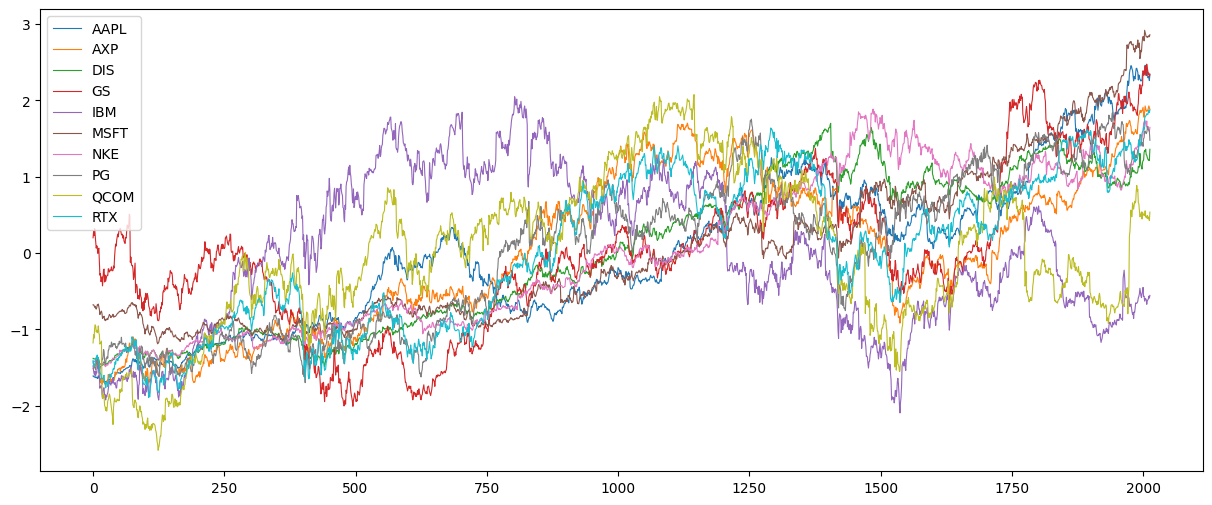

In [186]:
plt.figure(figsize=(15,6))
for i in range(len(dfs)):
  plt.plot(dfs_standard[i][:,3], linewidth=0.8, label=dir[i]) #plot closing price
plt.legend()

### **Concatenate**

In [187]:
print(np.array(dfs_standard).shape)
dfs_cat=np.concatenate(dfs_standard, axis=-1)
dfs_cat.shape

(10, 2014, 22)


(2014, 220)

### **Train-Test Split**

In [188]:
# dataset=np.array(APPL)
# X_train=[]
# X_test=[]
# for i in range(len(dfs)):
#   dataset=dfs_standard[i].tolist()
#   split=int(0.7*len(dataset))
#   X_train.append(dataset[0:split] )
#   X_test.append(dataset[split:] )

# print(len(X_train[0]))
# print(len(X_test[0]))

X=dfs_cat.tolist()
split=int(0.75*len(X))
X_train=X[0:split] 
X_test=X[split:] 

print(len(X_train))
print(len(X_test))

1510
504


In [189]:
#TODO: try to tune this
config = {
  'batch_size': 64,
  'lr':1e-4,
  'epochs': 30,
}

In [190]:
class TransformerDataset(Dataset):
    def __init__(self, data, indices, enc_seq_len, pred_seq_len) :
        super().__init__()
        self.data = data
        self.indices = indices
        self.enc_seq_len = enc_seq_len
        self.pred_seq_len = pred_seq_len

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, index):
        start, end = self.indices[index]

        sequence = self.data[start:end]

        src = sequence[:self.enc_seq_len]      #0~59 inclusive
        tgt = sequence[self.enc_seq_len-self.pred_seq_len+1 : self.enc_seq_len+1]     #56~60 inclusive
        true = sequence[self.enc_seq_len+1:]     #61~65 inclusive

        return src, tgt, true
    

In [191]:
def get_windows(data, window_size, step_size):
    start = 0
    end = window_size
    
    indices = []
    while end < len(data):      #proceed window by step size, count how many sequences 
        indices.append( (start, end) )
        start += step_size
        end += step_size
    return indices

torch.Size([128, 30, 220]) torch.Size([128, 10, 220])
x:  tensor([-1.2416, -1.5909, -1.1935, -0.6334, -0.2678, -0.0820, -0.1407, -0.4347,
        -0.0305, -0.0070, -0.0181,  0.4527,  0.5013,  0.4024,  0.7536,  1.0967,
         0.7590,  1.1360,  1.1395,  1.2298,  0.8496,  0.9777,  1.1973,  1.0314,
         1.1592,  1.4387,  0.9353,  1.1290,  1.0885,  1.1859])
tgt:  tensor([0.9777, 1.1973, 1.0314, 1.1592, 1.4387, 0.9353, 1.1290, 1.0885, 1.1859,
        1.3310])
y_train:  tensor([1.4813, 1.5321, 1.0325, 1.2676, 1.5517, 1.3813, 0.7811, 0.5468, 0.7025,
        0.5086])


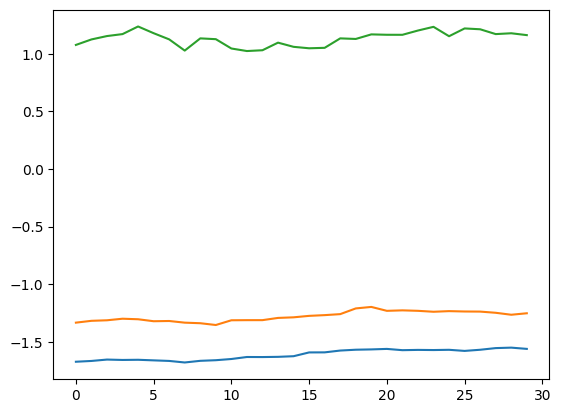

In [192]:
# Dataset Dataloader:
#TODO: tune context_len and pred_len
context_len=30
pred_len=10
window_size=context_len+pred_len+1
training_indices = get_windows(X_train, window_size, step_size=3) #TODO: Tune step size... 
val_indices = get_windows(X_test, window_size, step_size=1) #TODO: Tune step size... 
test_indices = get_windows(X, window_size, step_size=1) 

# print(training_indices)
train_data=TransformerDataset(torch.FloatTensor(X_train), training_indices, context_len, pred_len) 
val_data=TransformerDataset(torch.FloatTensor(X_test), val_indices, context_len, pred_len) 
test_data=TransformerDataset(torch.FloatTensor(X), test_indices, context_len, pred_len) 

train_loader = torch.utils.data.DataLoader(
    dataset     = train_data, 
    batch_size  = 128,
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    dataset     = val_data, 
    batch_size  = 24,
    drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    dataset     = test_data, 
    batch_size  = 1,
    pin_memory  = False
)

for batch in train_loader: 
    src, tgt, y_train=batch
    print(src.shape, tgt.shape)
    print("x: ", src[0,:,-1])   #60 days context  
    print("tgt: ", tgt[0,:,-1]) #should be next five days 
    print("y_train: ", y_train[0,:,-1])  #True label should shift by one to right
    plt.plot(src[0,:,3])
    plt.plot(src[1,:,3])
    plt.plot(src[2,:,3]) #
    break

### **Positional Encoder and Transformer**

In [193]:
class PositionalEncoder(nn.Module):
    def __init__(self,  max_seq_len = 5000, d_model = 512, dropout= 0.1,):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        time = torch.arange(0, max_seq_len).unsqueeze(1)
        self.positional_encoding = torch.zeros(1,max_seq_len, d_model).to(DEVICE)
        xx= (torch.arange(0,max_seq_len).reshape(-1, 1).to(DEVICE)) / torch.pow(10000, torch.arange(0, d_model, 2)/d_model).to(DEVICE)
        self.positional_encoding[:, :, 0::2] = torch.sin(xx)
        self.positional_encoding[:, :, 1::2] = torch.cos(xx)

        self.register_buffer('pe', self.positional_encoding)

    def forward(self, x) :
        x = x + self.positional_encoding[:,:x.shape[1]]
        x=self.dropout(x)
        return x


In [194]:
class Transformer(nn.Module):
    def __init__(self, input_dim=8, output_dim=1, d_model=512, nhead=8, num_encoder_layers=6, num_decoder_layers=6, dim_feedforward=2048, dropout=0.1,encode_seq_len=60,pred_seq_len=10):
        super(Transformer, self).__init__()
        self.nhead=nhead
        self.d_model=d_model
        self.encode_seq_len=encode_seq_len
        self.embedding = nn.Linear(input_dim, d_model) 
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        self.pred_seq_len=pred_seq_len
        self.linear_out = nn.Linear(d_model, output_dim)
        self.positional_encoding_layer = PositionalEncoder(encode_seq_len, d_model, dropout  )

    def forward(self, x, query, src_mask=None, tgt_mask=None):
        # print("in,",x.shape) #32 10 29, batch len feature
        batch_size, seq_len, feature=x.shape

        # #encode x
        x = self.embedding(x) 
        x = self.positional_encoding_layer(x)

        #encode query
        query=self.embedding(query) 

        encoder_out = self.encoder(x)
        decoder_out = self.decoder(query, encoder_out,tgt_mask=tgt_mask, memory_mask=src_mask )
        # print("asdasdasdasdasd",decoder_out.shape)

        # attn_weights = self.decoder.layers[-1].multihead_attn.attn_output_weights

        decoder_out = self.linear_out(decoder_out)
        
        return decoder_out


In [195]:
gc.collect()
torch.cuda.empty_cache()
len(dir)

10

In [196]:
#TODO: tune model parameters
model=Transformer(input_dim=dfs_cat.shape[-1], output_dim=len(dir), d_model=512, nhead=2, 
                  num_encoder_layers=4, num_decoder_layers=4, dim_feedforward=512, 
                  dropout=0.4, encode_seq_len=context_len, pred_seq_len=pred_len).to(device)
# print(x.size)
for x, y,z in train_loader: 
    x=torch.FloatTensor(x).to(device)
    y=torch.FloatTensor(y).to(device)
    out=model(x,y)
    print("x shape:", x.shape, "y shape:", y.shape)
    print("out shape:", out.shape)
    # summary(model, x1)
    break
print("context len:",model.encode_seq_len,"pred_len:", model.pred_seq_len)

x shape: torch.Size([128, 30, 220]) y shape: torch.Size([128, 10, 220])
out shape: torch.Size([128, 10, 10])
context len: 30 pred_len: 10


# Model Setup 

# Loss Function, Optimizers, Scheduler

In [197]:
optimizer   = torch.optim.Adam(model.parameters(), lr= config['lr'])
criterion   = torch.nn.SmoothL1Loss() 
scaler      = torch.cuda.amp.GradScaler()

# Optional (but Recommended): Create a custom class for a Teacher Force Schedule

# Train and Validation functions 


In [198]:
class Trainer():
  def __init__(self, model, loader, optimizer, criterion, scheduler, val_loader):
    self.model      = model
    self.loader     = loader
    self.optimizer  = optimizer
    self.criterion  = criterion
    self.train_plot=[]
    self.teacher=True
    self.val_loader=val_loader
    
  def train(self, teacher_forcing_rate):
      self.model.train() # set to training mode
      self.model.to(device)

      batch_bar = tqdm(total=len(self.loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
      running_loss        = 0.0

      for i, batch in enumerate(self.loader):
          self.optimizer.zero_grad()

          src, trg, y_train = batch

          src = src.to(device)
          trg = trg.to(device)
          y_train = y_train.to(device)

          batch_size = src.shape[0]


          y_pred = self.model(src, trg, src_mask=None, tgt_mask=None)

          #0,'Open',1,'High',2,'Low',3,'Close',4,'Volume'
          pred_what=3
          y_train_list=[]
          for j in range(len(dir)):
            y_train_list.append(y_train[:,:, pred_what + FEATURE *j ] )    #get Closing of each stocks
          
          y_trains=torch.stack(y_train_list, axis=-1).to(device)  #128, 7, 10
          # print(y_pred.shape)

          loss = criterion(y_pred, y_trains)    #TODO: try changing 8 to others, if want the model to learn other columns
          
          loss.backward()
          torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1e+6)
          optimizer.step()
          
          self.train_plot.append(loss.item())
          running_loss += loss.item()
          
          batch_bar.set_postfix(
              loss="{:.04f}".format(running_loss/(i+1)),
              lr="{:.04f}".format(float(self.optimizer.param_groups[0]['lr'])),
              # teacher_time="{:.04f}".format(teach/10)
               )
          batch_bar.update()

          del src, trg, y_train
          torch.cuda.empty_cache()

      batch_bar.close()

      return running_loss/len(self.loader)

  def validate(self):
      self.model.eval() # set to training mode
      self.model.to(device)

      batch_bar = tqdm(total=len(self.loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
      running_loss        = 0.0

      for i, batch in enumerate(self.val_loader):
          self.optimizer.zero_grad()

          src, trg, y_test = batch

          src = src.to(device)
          trg = trg.to(device)
          y_test = y_test.to(device)

          batch_size = src.shape[0]

          y_pred = self.model(src, trg, src_mask=None, tgt_mask=None)

          # #0,'Time',1,'Open',2,'High',3,'Low',4,'Close',5,'Volume',6,'change',7,'delta',8,'Moving Average'
          # pred_what=3
          # # print(y_pred[:,1].shape,y_test[:,1,pred_what].shape)
          # val_loss = criterion(y_pred[:,0], y_test[:,0,pred_what].reshape(-1,1))    #TODO: try changing 8 to others, if want the model to learn other columns
          pred_what=3
          y_test_list=[]
          for j in range(len(dir)):
            y_test_list.append(y_test[:,:, pred_what + FEATURE *j ] )    #get Closing of each stocks
          
          y_tests=torch.stack(y_test_list, axis=-1).to(device)  #128, 7, 10

          val_loss = criterion(y_pred, y_tests)    #TODO: try changing 8 to others, if want the model to learn other columns
          
          running_loss += val_loss.item()
          
          batch_bar.set_postfix(
              loss="{:.04f}".format(running_loss/(i+1))
               )
          batch_bar.update()

          del src, trg, y_test
          torch.cuda.empty_cache()

      batch_bar.close()

      return running_loss/len(self.loader)

  def test(self, test_loader):
        self.model.eval() # set to training mode
        self.model.to(device)
        batch_bar = tqdm(total=len(test_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
        prediction=[]
        for i, batch in enumerate(test_loader):
            self.optimizer.zero_grad()

            src, trg, y_test = batch

            src = src.to(device)
            trg = trg.to(device)

            batch_size = src.shape[0]


            y_pred = self.model(src, trg, src_mask=None, tgt_mask=None)

            prediction.append(y_pred)

            del src, trg, y_test
            torch.cuda.empty_cache()
            batch_bar.update()

        batch_bar.close()

        return prediction

In [199]:
gc.collect()
torch.cuda.empty_cache()

In [200]:
scheduler   = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.995)
trainer=Trainer(model, train_loader, optimizer, criterion,  scheduler, val_loader=val_loader)


Epoch: 1/300


	Train Loss 0.2332	 Learning Rate 0.0001000	 Validation Loss 1.6001

Epoch: 2/300


	Train Loss 0.1050	 Learning Rate 0.0000995	 Validation Loss 1.0094

Epoch: 3/300


	Train Loss 0.0832	 Learning Rate 0.0000990	 Validation Loss 0.7522

Epoch: 4/300


	Train Loss 0.0669	 Learning Rate 0.0000985	 Validation Loss 0.8336

Epoch: 5/300


	Train Loss 0.0576	 Learning Rate 0.0000980	 Validation Loss 0.9552

Epoch: 6/300


	Train Loss 0.0529	 Learning Rate 0.0000975	 Validation Loss 0.7873

Epoch: 7/300


	Train Loss 0.0491	 Learning Rate 0.0000970	 Validation Loss 0.7010

Epoch: 8/300


	Train Loss 0.0455	 Learning Rate 0.0000966	 Validation Loss 0.7516

Epoch: 9/300


	Train Loss 0.0425	 Learning Rate 0.0000961	 Validation Loss 0.8155

Epoch: 10/300


	Train Loss 0.0407	 Learning Rate 0.0000956	 Validation Loss 0.7357

Epoch: 11/300


	Train Loss 0.0386	 Learning Rate 0.0000951	 Validation Loss 0.7208

Epoch: 12/300


	Train Loss 0.0371	 Learning Rate 0.0000946	 Validation Loss 0.7231

Epoch: 13/300


	Train Loss 0.0358	 Learning Rate 0.0000942	 Validation Loss 0.7367

Epoch: 14/300


	Train Loss 0.0347	 Learning Rate 0.0000937	 Validation Loss 0.7339

Epoch: 15/300


	Train Loss 0.0333	 Learning Rate 0.0000932	 Validation Loss 0.6980

Epoch: 16/300


	Train Loss 0.0325	 Learning Rate 0.0000928	 Validation Loss 0.7036

Epoch: 17/300


	Train Loss 0.0314	 Learning Rate 0.0000923	 Validation Loss 0.7360

Epoch: 18/300


	Train Loss 0.0309	 Learning Rate 0.0000918	 Validation Loss 0.7312

Epoch: 19/300


	Train Loss 0.0297	 Learning Rate 0.0000914	 Validation Loss 0.7008

Epoch: 20/300


	Train Loss 0.0292	 Learning Rate 0.0000909	 Validation Loss 0.6941

Epoch: 21/300


	Train Loss 0.0283	 Learning Rate 0.0000905	 Validation Loss 0.7084

Epoch: 22/300


	Train Loss 0.0277	 Learning Rate 0.0000900	 Validation Loss 0.7084

Epoch: 23/300


	Train Loss 0.0275	 Learning Rate 0.0000896	 Validation Loss 0.6918

Epoch: 24/300


	Train Loss 0.0271	 Learning Rate 0.0000891	 Validation Loss 0.6758

Epoch: 25/300


	Train Loss 0.0262	 Learning Rate 0.0000887	 Validation Loss 0.7118

Epoch: 26/300


	Train Loss 0.0264	 Learning Rate 0.0000882	 Validation Loss 0.7043

Epoch: 27/300


	Train Loss 0.0258	 Learning Rate 0.0000878	 Validation Loss 0.7117

Epoch: 28/300


	Train Loss 0.0252	 Learning Rate 0.0000873	 Validation Loss 0.6898

Epoch: 29/300


	Train Loss 0.0248	 Learning Rate 0.0000869	 Validation Loss 0.6944

Epoch: 30/300


	Train Loss 0.0237	 Learning Rate 0.0000865	 Validation Loss 0.7012

Epoch: 31/300


	Train Loss 0.0238	 Learning Rate 0.0000860	 Validation Loss 0.6946

Epoch: 32/300


	Train Loss 0.0234	 Learning Rate 0.0000856	 Validation Loss 0.7229

Epoch: 33/300


	Train Loss 0.0230	 Learning Rate 0.0000852	 Validation Loss 0.6868

Epoch: 34/300


	Train Loss 0.0224	 Learning Rate 0.0000848	 Validation Loss 0.6865

Epoch: 35/300


	Train Loss 0.0227	 Learning Rate 0.0000843	 Validation Loss 0.7056

Epoch: 36/300


	Train Loss 0.0224	 Learning Rate 0.0000839	 Validation Loss 0.7086

Epoch: 37/300


	Train Loss 0.0220	 Learning Rate 0.0000835	 Validation Loss 0.6920

Epoch: 38/300


	Train Loss 0.0214	 Learning Rate 0.0000831	 Validation Loss 0.7062

Epoch: 39/300


	Train Loss 0.0213	 Learning Rate 0.0000827	 Validation Loss 0.7015

Epoch: 40/300


	Train Loss 0.0214	 Learning Rate 0.0000822	 Validation Loss 0.7052

Epoch: 41/300


	Train Loss 0.0213	 Learning Rate 0.0000818	 Validation Loss 0.6887

Epoch: 42/300


	Train Loss 0.0208	 Learning Rate 0.0000814	 Validation Loss 0.7082

Epoch: 43/300


	Train Loss 0.0205	 Learning Rate 0.0000810	 Validation Loss 0.7164

Epoch: 44/300


	Train Loss 0.0202	 Learning Rate 0.0000806	 Validation Loss 0.6922

Epoch: 45/300


	Train Loss 0.0198	 Learning Rate 0.0000802	 Validation Loss 0.6896

Epoch: 46/300


	Train Loss 0.0196	 Learning Rate 0.0000798	 Validation Loss 0.7023

Epoch: 47/300


	Train Loss 0.0194	 Learning Rate 0.0000794	 Validation Loss 0.7065

Epoch: 48/300


	Train Loss 0.0193	 Learning Rate 0.0000790	 Validation Loss 0.7001

Epoch: 49/300


	Train Loss 0.0186	 Learning Rate 0.0000786	 Validation Loss 0.7223

Epoch: 50/300


	Train Loss 0.0185	 Learning Rate 0.0000782	 Validation Loss 0.6983

Epoch: 51/300


	Train Loss 0.0184	 Learning Rate 0.0000778	 Validation Loss 0.6957

Epoch: 52/300


	Train Loss 0.0183	 Learning Rate 0.0000774	 Validation Loss 0.6781

Epoch: 53/300


	Train Loss 0.0179	 Learning Rate 0.0000771	 Validation Loss 0.7120

Epoch: 54/300


	Train Loss 0.0180	 Learning Rate 0.0000767	 Validation Loss 0.7133

Epoch: 55/300


	Train Loss 0.0178	 Learning Rate 0.0000763	 Validation Loss 0.7138

Epoch: 56/300


	Train Loss 0.0173	 Learning Rate 0.0000759	 Validation Loss 0.6901

Epoch: 57/300


	Train Loss 0.0177	 Learning Rate 0.0000755	 Validation Loss 0.6964

Epoch: 58/300


	Train Loss 0.0172	 Learning Rate 0.0000751	 Validation Loss 0.6994

Epoch: 59/300


	Train Loss 0.0170	 Learning Rate 0.0000748	 Validation Loss 0.7160

Epoch: 60/300


	Train Loss 0.0168	 Learning Rate 0.0000744	 Validation Loss 0.7024

Epoch: 61/300


	Train Loss 0.0164	 Learning Rate 0.0000740	 Validation Loss 0.6969

Epoch: 62/300


	Train Loss 0.0165	 Learning Rate 0.0000737	 Validation Loss 0.6971

Epoch: 63/300


	Train Loss 0.0164	 Learning Rate 0.0000733	 Validation Loss 0.6712

Epoch: 64/300


	Train Loss 0.0163	 Learning Rate 0.0000729	 Validation Loss 0.6917

Epoch: 65/300


	Train Loss 0.0160	 Learning Rate 0.0000726	 Validation Loss 0.7031

Epoch: 66/300


	Train Loss 0.0160	 Learning Rate 0.0000722	 Validation Loss 0.6983

Epoch: 67/300


	Train Loss 0.0158	 Learning Rate 0.0000718	 Validation Loss 0.6867

Epoch: 68/300


	Train Loss 0.0157	 Learning Rate 0.0000715	 Validation Loss 0.7276

Epoch: 69/300


	Train Loss 0.0155	 Learning Rate 0.0000711	 Validation Loss 0.7048

Epoch: 70/300


	Train Loss 0.0155	 Learning Rate 0.0000708	 Validation Loss 0.6990

Epoch: 71/300


	Train Loss 0.0153	 Learning Rate 0.0000704	 Validation Loss 0.6816

Epoch: 72/300


	Train Loss 0.0154	 Learning Rate 0.0000701	 Validation Loss 0.6924

Epoch: 73/300


	Train Loss 0.0149	 Learning Rate 0.0000697	 Validation Loss 0.6954

Epoch: 74/300


	Train Loss 0.0150	 Learning Rate 0.0000694	 Validation Loss 0.6896

Epoch: 75/300


	Train Loss 0.0147	 Learning Rate 0.0000690	 Validation Loss 0.7080

Epoch: 76/300


	Train Loss 0.0149	 Learning Rate 0.0000687	 Validation Loss 0.6888

Epoch: 77/300


	Train Loss 0.0146	 Learning Rate 0.0000683	 Validation Loss 0.6939

Epoch: 78/300


	Train Loss 0.0145	 Learning Rate 0.0000680	 Validation Loss 0.6807

Epoch: 79/300


	Train Loss 0.0144	 Learning Rate 0.0000676	 Validation Loss 0.7004

Epoch: 80/300


	Train Loss 0.0144	 Learning Rate 0.0000673	 Validation Loss 0.6960

Epoch: 81/300


	Train Loss 0.0142	 Learning Rate 0.0000670	 Validation Loss 0.6959

Epoch: 82/300


	Train Loss 0.0140	 Learning Rate 0.0000666	 Validation Loss 0.6793

Epoch: 83/300


	Train Loss 0.0139	 Learning Rate 0.0000663	 Validation Loss 0.7015

Epoch: 84/300


	Train Loss 0.0140	 Learning Rate 0.0000660	 Validation Loss 0.7011

Epoch: 85/300


	Train Loss 0.0139	 Learning Rate 0.0000656	 Validation Loss 0.6963

Epoch: 86/300


	Train Loss 0.0137	 Learning Rate 0.0000653	 Validation Loss 0.7017

Epoch: 87/300


	Train Loss 0.0135	 Learning Rate 0.0000650	 Validation Loss 0.6993

Epoch: 88/300


	Train Loss 0.0135	 Learning Rate 0.0000647	 Validation Loss 0.6900

Epoch: 89/300


	Train Loss 0.0134	 Learning Rate 0.0000643	 Validation Loss 0.6829

Epoch: 90/300


	Train Loss 0.0132	 Learning Rate 0.0000640	 Validation Loss 0.6944

Epoch: 91/300


	Train Loss 0.0135	 Learning Rate 0.0000637	 Validation Loss 0.7069

Epoch: 92/300


	Train Loss 0.0134	 Learning Rate 0.0000634	 Validation Loss 0.7021

Epoch: 93/300


	Train Loss 0.0132	 Learning Rate 0.0000631	 Validation Loss 0.6869

Epoch: 94/300


	Train Loss 0.0130	 Learning Rate 0.0000627	 Validation Loss 0.7142

Epoch: 95/300


	Train Loss 0.0130	 Learning Rate 0.0000624	 Validation Loss 0.6832

Epoch: 96/300


	Train Loss 0.0129	 Learning Rate 0.0000621	 Validation Loss 0.7112

Epoch: 97/300


	Train Loss 0.0130	 Learning Rate 0.0000618	 Validation Loss 0.7153

Epoch: 98/300


	Train Loss 0.0128	 Learning Rate 0.0000615	 Validation Loss 0.6885

Epoch: 99/300


	Train Loss 0.0127	 Learning Rate 0.0000612	 Validation Loss 0.6905

Epoch: 100/300


	Train Loss 0.0126	 Learning Rate 0.0000609	 Validation Loss 0.7037

Epoch: 101/300


	Train Loss 0.0125	 Learning Rate 0.0000606	 Validation Loss 0.7062

Epoch: 102/300


	Train Loss 0.0125	 Learning Rate 0.0000603	 Validation Loss 0.6925

Epoch: 103/300


	Train Loss 0.0123	 Learning Rate 0.0000600	 Validation Loss 0.7030

Epoch: 104/300


	Train Loss 0.0122	 Learning Rate 0.0000597	 Validation Loss 0.7073

Epoch: 105/300


	Train Loss 0.0121	 Learning Rate 0.0000594	 Validation Loss 0.6827

Epoch: 106/300


	Train Loss 0.0121	 Learning Rate 0.0000591	 Validation Loss 0.7023

Epoch: 107/300


	Train Loss 0.0120	 Learning Rate 0.0000588	 Validation Loss 0.6983

Epoch: 108/300


	Train Loss 0.0120	 Learning Rate 0.0000585	 Validation Loss 0.6980

Epoch: 109/300


	Train Loss 0.0118	 Learning Rate 0.0000582	 Validation Loss 0.6942

Epoch: 110/300


	Train Loss 0.0117	 Learning Rate 0.0000579	 Validation Loss 0.7080

Epoch: 111/300


	Train Loss 0.0117	 Learning Rate 0.0000576	 Validation Loss 0.6875

Epoch: 112/300


	Train Loss 0.0119	 Learning Rate 0.0000573	 Validation Loss 0.6956

Epoch: 113/300


	Train Loss 0.0118	 Learning Rate 0.0000570	 Validation Loss 0.6857

Epoch: 114/300


	Train Loss 0.0117	 Learning Rate 0.0000568	 Validation Loss 0.7072

Epoch: 115/300


	Train Loss 0.0115	 Learning Rate 0.0000565	 Validation Loss 0.7031

Epoch: 116/300


	Train Loss 0.0116	 Learning Rate 0.0000562	 Validation Loss 0.6960

Epoch: 117/300


	Train Loss 0.0115	 Learning Rate 0.0000559	 Validation Loss 0.6865

Epoch: 118/300


	Train Loss 0.0114	 Learning Rate 0.0000556	 Validation Loss 0.7064

Epoch: 119/300


	Train Loss 0.0112	 Learning Rate 0.0000554	 Validation Loss 0.6948

Epoch: 120/300


	Train Loss 0.0114	 Learning Rate 0.0000551	 Validation Loss 0.6985

Epoch: 121/300


	Train Loss 0.0114	 Learning Rate 0.0000548	 Validation Loss 0.7069

Epoch: 122/300


	Train Loss 0.0114	 Learning Rate 0.0000545	 Validation Loss 0.7150

Epoch: 123/300


	Train Loss 0.0113	 Learning Rate 0.0000543	 Validation Loss 0.6872

Epoch: 124/300


	Train Loss 0.0112	 Learning Rate 0.0000540	 Validation Loss 0.6888

Epoch: 125/300


	Train Loss 0.0110	 Learning Rate 0.0000537	 Validation Loss 0.6975

Epoch: 126/300


	Train Loss 0.0110	 Learning Rate 0.0000534	 Validation Loss 0.6968

Epoch: 127/300


	Train Loss 0.0111	 Learning Rate 0.0000532	 Validation Loss 0.7111

Epoch: 128/300


	Train Loss 0.0110	 Learning Rate 0.0000529	 Validation Loss 0.6935

Epoch: 129/300


	Train Loss 0.0109	 Learning Rate 0.0000526	 Validation Loss 0.6904

Epoch: 130/300


	Train Loss 0.0108	 Learning Rate 0.0000524	 Validation Loss 0.7066

Epoch: 131/300


	Train Loss 0.0108	 Learning Rate 0.0000521	 Validation Loss 0.7059

Epoch: 132/300


	Train Loss 0.0109	 Learning Rate 0.0000519	 Validation Loss 0.7045

Epoch: 133/300


	Train Loss 0.0107	 Learning Rate 0.0000516	 Validation Loss 0.6996

Epoch: 134/300


	Train Loss 0.0106	 Learning Rate 0.0000513	 Validation Loss 0.6950

Epoch: 135/300


	Train Loss 0.0108	 Learning Rate 0.0000511	 Validation Loss 0.7198

Epoch: 136/300


	Train Loss 0.0107	 Learning Rate 0.0000508	 Validation Loss 0.6832

Epoch: 137/300


	Train Loss 0.0105	 Learning Rate 0.0000506	 Validation Loss 0.7202

Epoch: 138/300


	Train Loss 0.0105	 Learning Rate 0.0000503	 Validation Loss 0.7133

Epoch: 139/300


	Train Loss 0.0104	 Learning Rate 0.0000501	 Validation Loss 0.6758

Epoch: 140/300


	Train Loss 0.0105	 Learning Rate 0.0000498	 Validation Loss 0.7072

Epoch: 141/300


	Train Loss 0.0107	 Learning Rate 0.0000496	 Validation Loss 0.7121

Epoch: 142/300


	Train Loss 0.0104	 Learning Rate 0.0000493	 Validation Loss 0.6894

Epoch: 143/300


	Train Loss 0.0103	 Learning Rate 0.0000491	 Validation Loss 0.6864

Epoch: 144/300


	Train Loss 0.0104	 Learning Rate 0.0000488	 Validation Loss 0.7054

Epoch: 145/300


	Train Loss 0.0103	 Learning Rate 0.0000486	 Validation Loss 0.6926

Epoch: 146/300


	Train Loss 0.0104	 Learning Rate 0.0000483	 Validation Loss 0.6926

Epoch: 147/300


	Train Loss 0.0103	 Learning Rate 0.0000481	 Validation Loss 0.7017

Epoch: 148/300


	Train Loss 0.0104	 Learning Rate 0.0000479	 Validation Loss 0.6996

Epoch: 149/300


	Train Loss 0.0102	 Learning Rate 0.0000476	 Validation Loss 0.7038

Epoch: 150/300


	Train Loss 0.0102	 Learning Rate 0.0000474	 Validation Loss 0.6923

Epoch: 151/300


	Train Loss 0.0101	 Learning Rate 0.0000471	 Validation Loss 0.7076

Epoch: 152/300


	Train Loss 0.0100	 Learning Rate 0.0000469	 Validation Loss 0.7123

Epoch: 153/300


	Train Loss 0.0100	 Learning Rate 0.0000467	 Validation Loss 0.7016

Epoch: 154/300


	Train Loss 0.0101	 Learning Rate 0.0000464	 Validation Loss 0.6933

Epoch: 155/300


	Train Loss 0.0100	 Learning Rate 0.0000462	 Validation Loss 0.7080

Epoch: 156/300


	Train Loss 0.0100	 Learning Rate 0.0000460	 Validation Loss 0.6977

Epoch: 157/300


	Train Loss 0.0098	 Learning Rate 0.0000458	 Validation Loss 0.6926

Epoch: 158/300


	Train Loss 0.0099	 Learning Rate 0.0000455	 Validation Loss 0.7112

Epoch: 159/300


	Train Loss 0.0098	 Learning Rate 0.0000453	 Validation Loss 0.7076

Epoch: 160/300


	Train Loss 0.0097	 Learning Rate 0.0000451	 Validation Loss 0.6949

Epoch: 161/300


	Train Loss 0.0097	 Learning Rate 0.0000448	 Validation Loss 0.6997

Epoch: 162/300


	Train Loss 0.0098	 Learning Rate 0.0000446	 Validation Loss 0.7024

Epoch: 163/300


	Train Loss 0.0097	 Learning Rate 0.0000444	 Validation Loss 0.7042

Epoch: 164/300


	Train Loss 0.0096	 Learning Rate 0.0000442	 Validation Loss 0.6877

Epoch: 165/300


	Train Loss 0.0096	 Learning Rate 0.0000440	 Validation Loss 0.7032

Epoch: 166/300


	Train Loss 0.0098	 Learning Rate 0.0000437	 Validation Loss 0.7111

Epoch: 167/300


	Train Loss 0.0097	 Learning Rate 0.0000435	 Validation Loss 0.7043

Epoch: 168/300


	Train Loss 0.0095	 Learning Rate 0.0000433	 Validation Loss 0.6964

Epoch: 169/300


	Train Loss 0.0095	 Learning Rate 0.0000431	 Validation Loss 0.6967

Epoch: 170/300


	Train Loss 0.0096	 Learning Rate 0.0000429	 Validation Loss 0.7095

Epoch: 171/300


	Train Loss 0.0094	 Learning Rate 0.0000427	 Validation Loss 0.7001

Epoch: 172/300


	Train Loss 0.0093	 Learning Rate 0.0000424	 Validation Loss 0.6978

Epoch: 173/300


	Train Loss 0.0094	 Learning Rate 0.0000422	 Validation Loss 0.6950

Epoch: 174/300


	Train Loss 0.0093	 Learning Rate 0.0000420	 Validation Loss 0.6962

Epoch: 175/300


	Train Loss 0.0093	 Learning Rate 0.0000418	 Validation Loss 0.7006

Epoch: 176/300


	Train Loss 0.0093	 Learning Rate 0.0000416	 Validation Loss 0.7180

Epoch: 177/300


	Train Loss 0.0094	 Learning Rate 0.0000414	 Validation Loss 0.6862

Epoch: 178/300


	Train Loss 0.0093	 Learning Rate 0.0000412	 Validation Loss 0.6904

Epoch: 179/300


	Train Loss 0.0093	 Learning Rate 0.0000410	 Validation Loss 0.7018

Epoch: 180/300


	Train Loss 0.0092	 Learning Rate 0.0000408	 Validation Loss 0.6934

Epoch: 181/300


	Train Loss 0.0091	 Learning Rate 0.0000406	 Validation Loss 0.6947

Epoch: 182/300


	Train Loss 0.0092	 Learning Rate 0.0000404	 Validation Loss 0.6921

Epoch: 183/300


	Train Loss 0.0092	 Learning Rate 0.0000402	 Validation Loss 0.7043

Epoch: 184/300


	Train Loss 0.0091	 Learning Rate 0.0000400	 Validation Loss 0.6986

Epoch: 185/300


	Train Loss 0.0091	 Learning Rate 0.0000398	 Validation Loss 0.6911

Epoch: 186/300


	Train Loss 0.0091	 Learning Rate 0.0000396	 Validation Loss 0.6911

Epoch: 187/300


	Train Loss 0.0092	 Learning Rate 0.0000394	 Validation Loss 0.7003

Epoch: 188/300


	Train Loss 0.0091	 Learning Rate 0.0000392	 Validation Loss 0.7042

Epoch: 189/300


	Train Loss 0.0091	 Learning Rate 0.0000390	 Validation Loss 0.6898

Epoch: 190/300


	Train Loss 0.0090	 Learning Rate 0.0000388	 Validation Loss 0.6902

Epoch: 191/300


	Train Loss 0.0090	 Learning Rate 0.0000386	 Validation Loss 0.7142

Epoch: 192/300


	Train Loss 0.0091	 Learning Rate 0.0000384	 Validation Loss 0.7000

Epoch: 193/300


	Train Loss 0.0089	 Learning Rate 0.0000382	 Validation Loss 0.6974

Epoch: 194/300


	Train Loss 0.0089	 Learning Rate 0.0000380	 Validation Loss 0.6997

Epoch: 195/300


	Train Loss 0.0091	 Learning Rate 0.0000378	 Validation Loss 0.6898

Epoch: 196/300


	Train Loss 0.0090	 Learning Rate 0.0000376	 Validation Loss 0.7007

Epoch: 197/300


	Train Loss 0.0090	 Learning Rate 0.0000374	 Validation Loss 0.7074

Epoch: 198/300


	Train Loss 0.0089	 Learning Rate 0.0000373	 Validation Loss 0.6932

Epoch: 199/300


	Train Loss 0.0089	 Learning Rate 0.0000371	 Validation Loss 0.6922

Epoch: 200/300


	Train Loss 0.0090	 Learning Rate 0.0000369	 Validation Loss 0.7116

Epoch: 201/300


	Train Loss 0.0089	 Learning Rate 0.0000367	 Validation Loss 0.7023

Epoch: 202/300


	Train Loss 0.0087	 Learning Rate 0.0000365	 Validation Loss 0.6905

Epoch: 203/300


	Train Loss 0.0087	 Learning Rate 0.0000363	 Validation Loss 0.7025

Epoch: 204/300


	Train Loss 0.0087	 Learning Rate 0.0000361	 Validation Loss 0.6994

Epoch: 205/300


	Train Loss 0.0088	 Learning Rate 0.0000360	 Validation Loss 0.6931

Epoch: 206/300


	Train Loss 0.0088	 Learning Rate 0.0000358	 Validation Loss 0.6933

Epoch: 207/300


	Train Loss 0.0088	 Learning Rate 0.0000356	 Validation Loss 0.7039

Epoch: 208/300


	Train Loss 0.0087	 Learning Rate 0.0000354	 Validation Loss 0.6873

Epoch: 209/300


	Train Loss 0.0086	 Learning Rate 0.0000353	 Validation Loss 0.6961

Epoch: 210/300


	Train Loss 0.0086	 Learning Rate 0.0000351	 Validation Loss 0.6943

Epoch: 211/300


	Train Loss 0.0088	 Learning Rate 0.0000349	 Validation Loss 0.6939

Epoch: 212/300


	Train Loss 0.0087	 Learning Rate 0.0000347	 Validation Loss 0.6955

Epoch: 213/300


	Train Loss 0.0088	 Learning Rate 0.0000346	 Validation Loss 0.6912

Epoch: 214/300


	Train Loss 0.0084	 Learning Rate 0.0000344	 Validation Loss 0.6920

Epoch: 215/300


	Train Loss 0.0086	 Learning Rate 0.0000342	 Validation Loss 0.7009

Epoch: 216/300


	Train Loss 0.0086	 Learning Rate 0.0000340	 Validation Loss 0.7089

Epoch: 217/300


	Train Loss 0.0085	 Learning Rate 0.0000339	 Validation Loss 0.7102

Epoch: 218/300


	Train Loss 0.0086	 Learning Rate 0.0000337	 Validation Loss 0.7091

Epoch: 219/300


	Train Loss 0.0085	 Learning Rate 0.0000335	 Validation Loss 0.6929

Epoch: 220/300


	Train Loss 0.0085	 Learning Rate 0.0000334	 Validation Loss 0.6927

Epoch: 221/300


	Train Loss 0.0085	 Learning Rate 0.0000332	 Validation Loss 0.6915

Epoch: 222/300


	Train Loss 0.0084	 Learning Rate 0.0000330	 Validation Loss 0.7052

Epoch: 223/300


	Train Loss 0.0085	 Learning Rate 0.0000329	 Validation Loss 0.6891

Epoch: 224/300


	Train Loss 0.0085	 Learning Rate 0.0000327	 Validation Loss 0.6952

Epoch: 225/300


	Train Loss 0.0084	 Learning Rate 0.0000325	 Validation Loss 0.6990

Epoch: 226/300


	Train Loss 0.0084	 Learning Rate 0.0000324	 Validation Loss 0.7016

Epoch: 227/300


	Train Loss 0.0084	 Learning Rate 0.0000322	 Validation Loss 0.6958

Epoch: 228/300


	Train Loss 0.0085	 Learning Rate 0.0000321	 Validation Loss 0.7116

Epoch: 229/300


	Train Loss 0.0083	 Learning Rate 0.0000319	 Validation Loss 0.6959

Epoch: 230/300


	Train Loss 0.0085	 Learning Rate 0.0000317	 Validation Loss 0.7033

Epoch: 231/300


	Train Loss 0.0084	 Learning Rate 0.0000316	 Validation Loss 0.7043

Epoch: 232/300


	Train Loss 0.0083	 Learning Rate 0.0000314	 Validation Loss 0.6941

Epoch: 233/300


	Train Loss 0.0083	 Learning Rate 0.0000313	 Validation Loss 0.7025

Epoch: 234/300


	Train Loss 0.0083	 Learning Rate 0.0000311	 Validation Loss 0.6961

Epoch: 235/300


	Train Loss 0.0083	 Learning Rate 0.0000309	 Validation Loss 0.7015

Epoch: 236/300


	Train Loss 0.0082	 Learning Rate 0.0000308	 Validation Loss 0.7005

Epoch: 237/300


	Train Loss 0.0084	 Learning Rate 0.0000306	 Validation Loss 0.7043

Epoch: 238/300


	Train Loss 0.0083	 Learning Rate 0.0000305	 Validation Loss 0.6977

Epoch: 239/300


	Train Loss 0.0083	 Learning Rate 0.0000303	 Validation Loss 0.7054

Epoch: 240/300


	Train Loss 0.0081	 Learning Rate 0.0000302	 Validation Loss 0.6919

Epoch: 241/300


	Train Loss 0.0083	 Learning Rate 0.0000300	 Validation Loss 0.6994

Epoch: 242/300


	Train Loss 0.0081	 Learning Rate 0.0000299	 Validation Loss 0.7034

Epoch: 243/300


	Train Loss 0.0081	 Learning Rate 0.0000297	 Validation Loss 0.6971

Epoch: 244/300


	Train Loss 0.0081	 Learning Rate 0.0000296	 Validation Loss 0.6961

Epoch: 245/300


	Train Loss 0.0082	 Learning Rate 0.0000294	 Validation Loss 0.6978

Epoch: 246/300


	Train Loss 0.0082	 Learning Rate 0.0000293	 Validation Loss 0.6952

Epoch: 247/300


	Train Loss 0.0081	 Learning Rate 0.0000291	 Validation Loss 0.7025

Epoch: 248/300


	Train Loss 0.0081	 Learning Rate 0.0000290	 Validation Loss 0.6856

Epoch: 249/300


	Train Loss 0.0080	 Learning Rate 0.0000288	 Validation Loss 0.6984

Epoch: 250/300


	Train Loss 0.0082	 Learning Rate 0.0000287	 Validation Loss 0.6919

Epoch: 251/300


	Train Loss 0.0082	 Learning Rate 0.0000286	 Validation Loss 0.7012

Epoch: 252/300


	Train Loss 0.0080	 Learning Rate 0.0000284	 Validation Loss 0.7015

Epoch: 253/300


	Train Loss 0.0081	 Learning Rate 0.0000283	 Validation Loss 0.6942

Epoch: 254/300


	Train Loss 0.0080	 Learning Rate 0.0000281	 Validation Loss 0.6866

Epoch: 255/300


	Train Loss 0.0081	 Learning Rate 0.0000280	 Validation Loss 0.7008

Epoch: 256/300


	Train Loss 0.0080	 Learning Rate 0.0000279	 Validation Loss 0.6902

Epoch: 257/300


	Train Loss 0.0080	 Learning Rate 0.0000277	 Validation Loss 0.6932

Epoch: 258/300


	Train Loss 0.0081	 Learning Rate 0.0000276	 Validation Loss 0.7008

Epoch: 259/300


	Train Loss 0.0080	 Learning Rate 0.0000274	 Validation Loss 0.7024

Epoch: 260/300


	Train Loss 0.0080	 Learning Rate 0.0000273	 Validation Loss 0.6856

Epoch: 261/300


	Train Loss 0.0080	 Learning Rate 0.0000272	 Validation Loss 0.6925

Epoch: 262/300


	Train Loss 0.0080	 Learning Rate 0.0000270	 Validation Loss 0.6987

Epoch: 263/300


	Train Loss 0.0080	 Learning Rate 0.0000269	 Validation Loss 0.6998

Epoch: 264/300


	Train Loss 0.0079	 Learning Rate 0.0000268	 Validation Loss 0.6996

Epoch: 265/300


	Train Loss 0.0079	 Learning Rate 0.0000266	 Validation Loss 0.6949

Epoch: 266/300


	Train Loss 0.0080	 Learning Rate 0.0000265	 Validation Loss 0.7123

Epoch: 267/300


	Train Loss 0.0079	 Learning Rate 0.0000264	 Validation Loss 0.6933

Epoch: 268/300


	Train Loss 0.0079	 Learning Rate 0.0000262	 Validation Loss 0.6988

Epoch: 269/300


	Train Loss 0.0078	 Learning Rate 0.0000261	 Validation Loss 0.6963

Epoch: 270/300


	Train Loss 0.0079	 Learning Rate 0.0000260	 Validation Loss 0.6984

Epoch: 271/300


	Train Loss 0.0079	 Learning Rate 0.0000258	 Validation Loss 0.7037

Epoch: 272/300


	Train Loss 0.0079	 Learning Rate 0.0000257	 Validation Loss 0.7012

Epoch: 273/300


	Train Loss 0.0078	 Learning Rate 0.0000256	 Validation Loss 0.7021

Epoch: 274/300


	Train Loss 0.0078	 Learning Rate 0.0000255	 Validation Loss 0.7031

Epoch: 275/300


	Train Loss 0.0078	 Learning Rate 0.0000253	 Validation Loss 0.6943

Epoch: 276/300


	Train Loss 0.0077	 Learning Rate 0.0000252	 Validation Loss 0.6919

Epoch: 277/300


	Train Loss 0.0078	 Learning Rate 0.0000251	 Validation Loss 0.7011

Epoch: 278/300


	Train Loss 0.0078	 Learning Rate 0.0000249	 Validation Loss 0.7083

Epoch: 279/300


	Train Loss 0.0076	 Learning Rate 0.0000248	 Validation Loss 0.6968

Epoch: 280/300


	Train Loss 0.0077	 Learning Rate 0.0000247	 Validation Loss 0.7047

Epoch: 281/300


	Train Loss 0.0077	 Learning Rate 0.0000246	 Validation Loss 0.6975

Epoch: 282/300


	Train Loss 0.0077	 Learning Rate 0.0000245	 Validation Loss 0.6937

Epoch: 283/300


	Train Loss 0.0077	 Learning Rate 0.0000243	 Validation Loss 0.7032

Epoch: 284/300


	Train Loss 0.0076	 Learning Rate 0.0000242	 Validation Loss 0.6992

Epoch: 285/300


	Train Loss 0.0077	 Learning Rate 0.0000241	 Validation Loss 0.7059

Epoch: 286/300


	Train Loss 0.0077	 Learning Rate 0.0000240	 Validation Loss 0.6857

Epoch: 287/300


	Train Loss 0.0077	 Learning Rate 0.0000238	 Validation Loss 0.6934

Epoch: 288/300


	Train Loss 0.0078	 Learning Rate 0.0000237	 Validation Loss 0.6992

Epoch: 289/300


	Train Loss 0.0078	 Learning Rate 0.0000236	 Validation Loss 0.7078

Epoch: 290/300


	Train Loss 0.0077	 Learning Rate 0.0000235	 Validation Loss 0.7053

Epoch: 291/300


	Train Loss 0.0076	 Learning Rate 0.0000234	 Validation Loss 0.7007

Epoch: 292/300


	Train Loss 0.0076	 Learning Rate 0.0000233	 Validation Loss 0.7025

Epoch: 293/300


	Train Loss 0.0076	 Learning Rate 0.0000231	 Validation Loss 0.7006

Epoch: 294/300


	Train Loss 0.0077	 Learning Rate 0.0000230	 Validation Loss 0.7030

Epoch: 295/300


	Train Loss 0.0077	 Learning Rate 0.0000229	 Validation Loss 0.6973

Epoch: 296/300


	Train Loss 0.0076	 Learning Rate 0.0000228	 Validation Loss 0.6946

Epoch: 297/300


	Train Loss 0.0076	 Learning Rate 0.0000227	 Validation Loss 0.6949

Epoch: 298/300


	Train Loss 0.0075	 Learning Rate 0.0000226	 Validation Loss 0.7031

Epoch: 299/300


	Train Loss 0.0075	 Learning Rate 0.0000225	 Validation Loss 0.7035

Epoch: 300/300


	Train Loss 0.0075	 Learning Rate 0.0000223	 Validation Loss 0.6953


Text(0.5, 1.0, 'Validation loss')

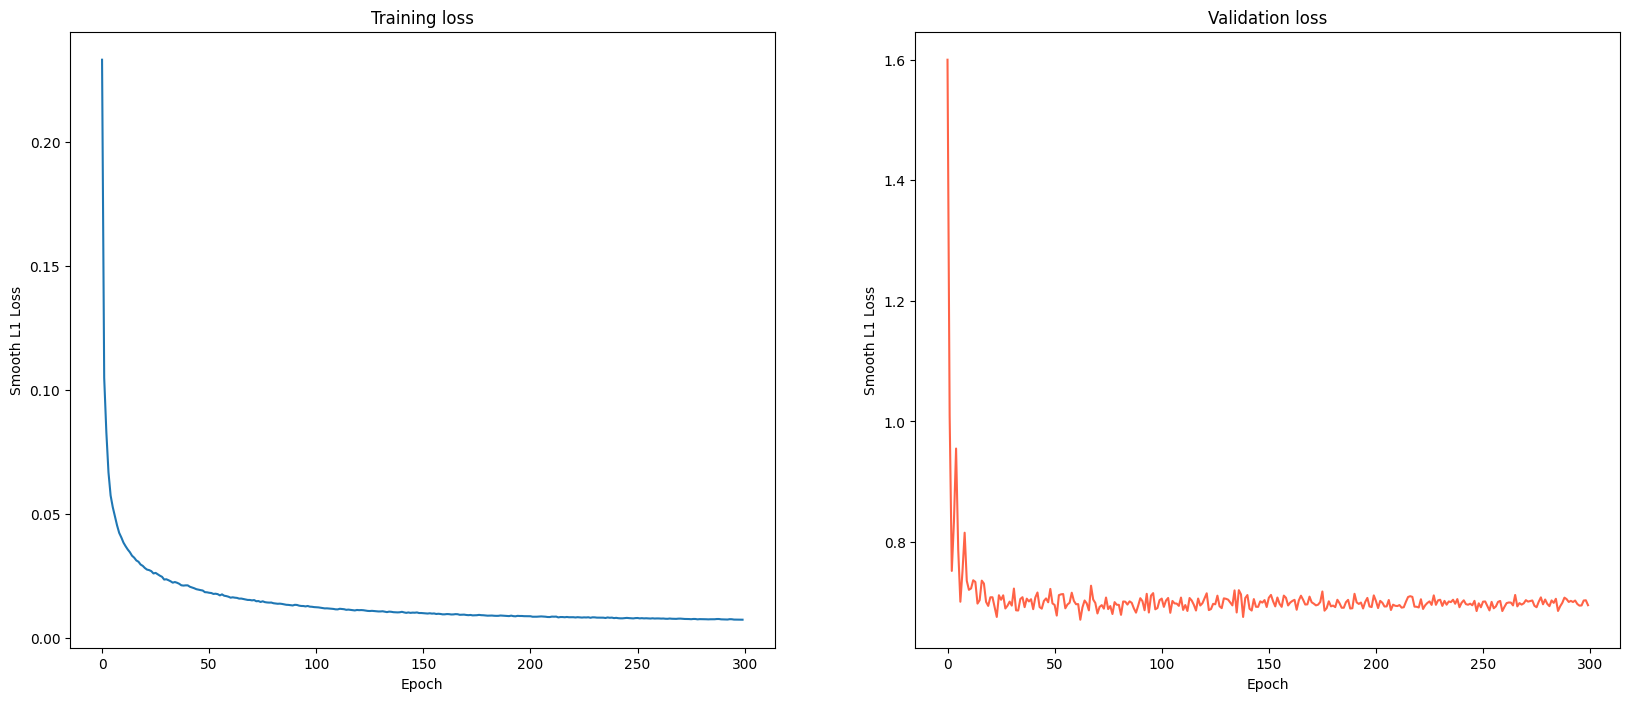

In [201]:
optimizer.param_groups[0]['lr']=0.0001

epoch_plot=[]
val_plot=[]
num_epochs=300
counter=0
teacher_forcing_rate=1.
for epoch in range(0, num_epochs):

    # Call train and validate 
    print("\nEpoch: {}/{}".format(epoch+1, num_epochs))
    
    curr_lr = float(optimizer.param_groups[0]['lr'])
    
    train_loss              = trainer.train(teacher_forcing_rate=teacher_forcing_rate)
    epoch_plot.append(train_loss)

    val_loss              = trainer.validate()

    val_plot.append(val_loss)

    teacher_forcing_rate=max(teacher_forcing_rate-0.05, 0.5)
    if teacher_forcing_rate<0.5:
      teacher_forcing_rate=0.9

    # trainer.teacher_forcing_ratio=max(trainer.teacher_forcing_ratio-0.05,0.1)
    scheduler.step()

    print("\tTrain Loss {:.04f}\t Learning Rate {:.07f}\t Validation Loss {:.04f}".format(train_loss, curr_lr, val_loss))

fig, ax=plt.subplots(1,2, figsize=(20,8))
# ax[0].plot(trainer.train_plot)
ax[0].plot(epoch_plot)
ax[0].set_ylabel("Smooth L1 Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_title("Training loss")

ax[1].plot(val_plot, color='tomato')
ax[1].set_ylabel("Smooth L1 Loss")
ax[1].set_xlabel("Epoch")
ax[1].set_title("Validation loss")


In [23]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [202]:
path="/content/drive/MyDrive/stockprices/checkpoint_22indicators.pth"
torch.save({'model_state_dict':trainer.model.state_dict(),
                  'optimizer_state_dict':trainer.optimizer.state_dict(),
                  'epoch': epoch}, path)

In [24]:
path="/content/drive/MyDrive/stockprices/checkpoint_ALL.pth"
checkpoint = torch.load(path)
model.load_state_dict(checkpoint['model_state_dict'])
trainer.model=model

### **# Testing: Generate each day's predictions**

In [203]:
#window size: 65, context_len:5, pred_len: 5 
prediction=trainer.test(test_loader)
prediction=[i.cpu().detach().numpy() for i in prediction]

In [204]:
print(prediction[0].shape)
len(prediction)

(1, 10, 10)


1973

In [205]:
gc.collect()
torch.cuda.empty_cache()
predictions=np.concatenate(prediction, axis=0)
print(predictions.shape)


(1973, 10, 10)


In [111]:
# plt.plot(predictions[:,0,0])
# plt.plot(np.array(dfs_standard)[0,:,3])

### **Scale back original Price**

In [206]:
prediction_back=[]
for i in range(len(dir)):
  sc=Scalers[i]
  prediction_i=predictions[:,0,i]
  prediction_i_padded=np.pad(prediction_i,(context_len+1, pred_len),'constant', constant_values=(prediction_i[0], prediction_i[-1]))
  dfs_copy=np.array(dfs.copy())[i]
  # print(dfs_copy.shape)
  dfs_copy[:,3]=prediction_i_padded
  inverse=sc.inverse_transform(dfs_copy)[:,3]
  prediction_back.append(inverse)

print(np.array(prediction_back).shape)

(10, 2014)


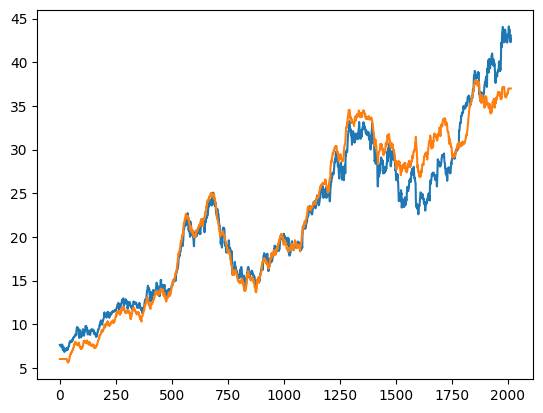

In [207]:
plt.plot(np.array(dfs)[0,:,3])
plt.plot(prediction_back[0])

### **Plot Predictions**

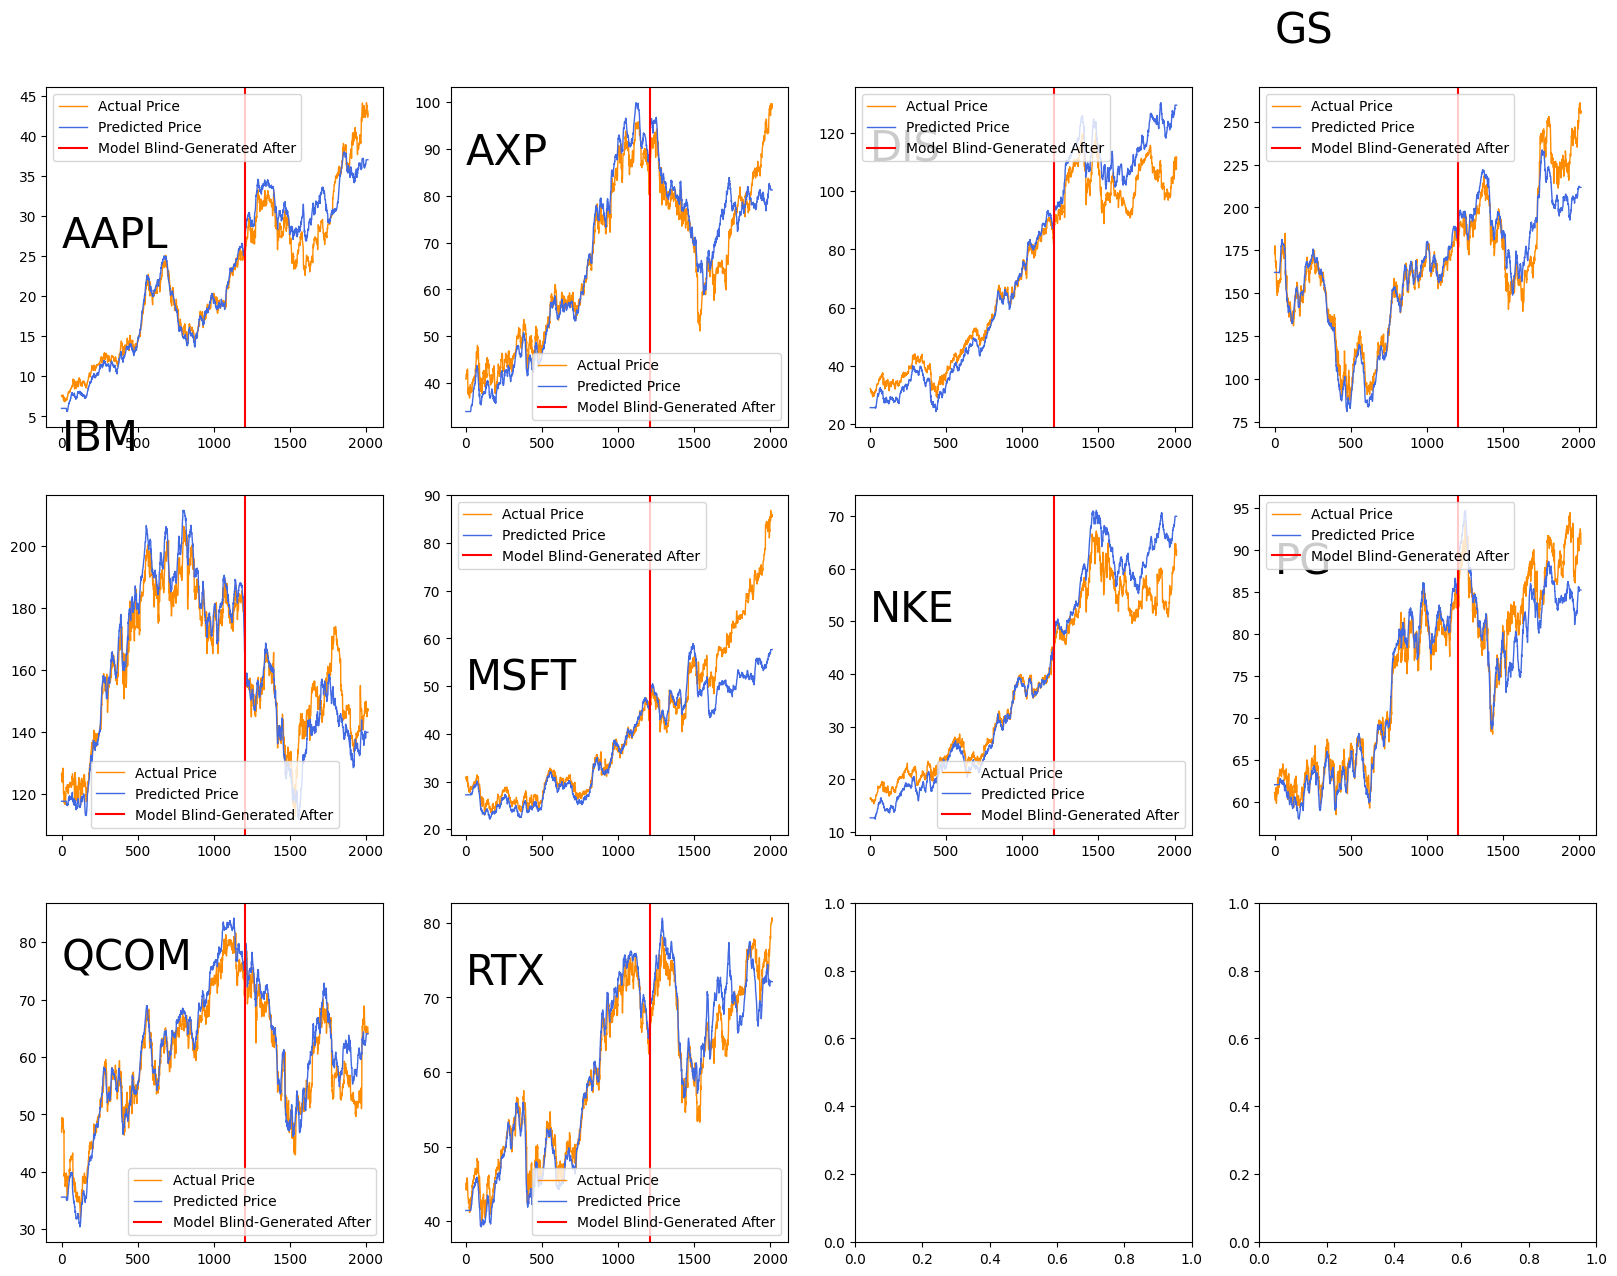

In [209]:
fig, ax=plt.subplots(3,4, figsize=(20,15))
ax=ax.ravel()
for i in range(len(dir)):
  ax[i].plot(np.array(dfs)[i,:,3], label='Actual Price', color='darkorange', linewidth=1)
  # ax[i].plot(np.array(actual_data)[:,7], label='Moving Average', color='cyan')
  # ax[i].bar(x=np.arange(0,len(dataset)), height=np.array(actual_data)[:,4]/5000000 , label='Volume', color='lightskyblue', alpha=0.3)

  ax[i].plot( prediction_back[i], label='Predicted Price',color='royalblue', linewidth=1)
  ax[i].axvline(x = int(dfs_cat.shape[0]*0.6), color='r', label="Model Blind-Generated After")
  ax[i].legend()
  # ax[i].xlabel("Days")
  # ax[i].ylabel("Prices")
  ax[i].annotate(dir[i],xy=(0, np.mean(prediction_back[i]) ),textcoords='offset points', fontsize=30)
  # ax[i].savefig("AAPL1.png", transparent = False)
plt.savefig("10Stocks", transparent = False)

### **Retrieve all predictions to feed in agent**

In [210]:
prediction_all=[]
for i in range(len(dir)):
  sc=Scalers[i]

  prediction_win=[]
  for j in range(pred_len):  #retieve all prediction each day
    prediction_i=predictions[:,j,i]
    prediction_i_padded=np.pad(prediction_i,(context_len+1, pred_len),'constant', constant_values=(prediction_i[0], prediction_i[-1]))
    dfs_copy=np.array(dfs.copy())[i]
    dfs_copy[:,3]=prediction_i_padded
    inverse=sc.inverse_transform(dfs_copy)[:,3]
    prediction_win.append( inverse)
  prediction_all.append(np.transpose(prediction_win))

print(np.array(prediction_all).shape)

(10, 2014, 10)


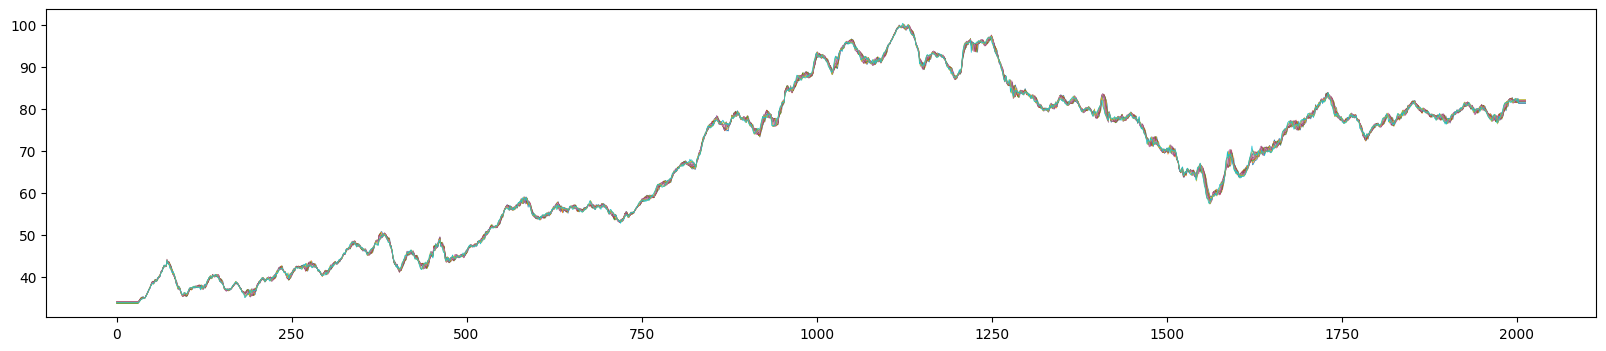

In [211]:
plt.figure(figsize=(20,4))
prediction_all=np.array(prediction_all)
for i in range(len(prediction_all)):
  plt.plot(prediction_all[1,:,i], linewidth=0.5)

### **Store in Dataframe and toCSV**

In [212]:
dff=[]
for i in range(len(dir)):
  df_out=pd.DataFrame(prediction_all[i],  columns=np.arange(0, pred_len))
  df_out.to_csv(dir[i]+"_Pred.csv")
  dff.append(df_out)


In [213]:
dff[1]

,0,1,2,3,4,5,6,7,8,9
0,33.900961,33.788218,33.791928,34.173299,34.092114,34.200383,34.108472,34.031908,33.942257,33.927369
1,33.900961,33.788218,33.791928,34.173299,34.092114,34.200383,34.108472,34.031908,33.942257,33.927369
2,33.900961,33.788218,33.791928,34.173299,34.092114,34.200383,34.108472,34.031908,33.942257,33.927369
3,33.900961,33.788218,33.791928,34.173299,34.092114,34.200383,34.108472,34.031908,33.942257,33.927369
4,33.900961,33.788218,33.791928,34.173299,34.092114,34.200383,34.108472,34.031908,33.942257,33.927369
...,...,...,...,...,...,...,...,...,...,...
2009,81.266248,81.676136,81.717946,81.920936,82.076764,81.785098,81.596319,81.355663,82.173623,81.424723
2010,81.266248,81.676136,81.717946,81.920936,82.076764,81.785098,81.596319,81.355663,82.173623,81.424723
2011,81.266248,81.676136,81.717946,81.920936,82.076764,81.785098,81.596319,81.355663,82.173623,81.424723
2012,81.266248,81.676136,81.717946,81.920936,82.076764,81.785098,81.596319,81.355663,82.173623,81.424723


In [ ]:
# #window size: 65, context_len:5, pred_len: 5 
# pp=[]
# pbar = tqdm(total=800,desc="predicting...")
# for i in range(800):
#   query=dataset[context_len-1+i:window_size-1+i]
#   tar=torch.FloatTensor(query).unsqueeze(0).to(device)   #1,5, 9
#   src=torch.FloatTensor(dataset[0+i: context_len+i]).unsqueeze(0).to(device)   #1, 65,9

#   out=trainer.model(src,tar) 
#   o=out.cpu().detach().numpy()[0,1]  
#   pp.append(o)
#   pbar.update()
# pbar.close()
# pp=np.squeeze(pp)
# pp.shape

In [ ]:
# #0,'Time',1,'Open',2,'High',3,'Low',4,'Close',5,'Volume',6,'change',7,'delta',8,'Moving Average'
# plt.figure(figsize=(10,8))
# plt.plot(np.array(dataset)[:1100,4], label='Actual Price', color='darkorange', linewidth=1)
# plt.plot(np.array(dataset)[:1100,8], label='Moving Average', color='cyan')
# plt.bar(x=np.arange(0,1100), height=np.array(dataset)[:1100,5]/5, label='Volume', color='lightskyblue', alpha=0.3)
# plt.annotate("GOOGL",xy=(0.3,0.6),textcoords='offset points')
# plt.plot(np.arange(context_len,800+context_len), pp, label='Predicted Price',color='royalblue', linewidth=0.5)
# plt.legend()
# # plt.ylim(200,400)

In [ ]:
# import seaborn as sns

In [ ]:
# def test_for_agent( model, test_loader):
#       model.eval() # set to training mode
#       model.to(device)
#       batch_bar = tqdm(total=len(test_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
#       prediction=[]
#       for i, batch in enumerate(test_loader):
#           # self.optimizer.zero_grad()

#           src, trg, y_test = batch

#           src = src.to(device)
#           trg = trg.to(device)

#           batch_size = src.shape[0]

#           y_pred = model(src, trg, src_mask=None, tgt_mask=None)
#           prediction.append(y_pred[0])

#           #0,'Time',1,'Open',2,'High',3,'Low',4,'Close',5,'Volume',6,'change',7,'delta',8,'Moving Average'
#           del src, trg, y_test
#           torch.cuda.empty_cache()
#           batch_bar.update()

#       batch_bar.close()

#       return prediction

In [ ]:
# prediction=test_for_agent(model=trainer.model, test_loader=test_loader)
# prediction=[i.cpu().detach().numpy() for i in prediction]
# prediction

In [ ]:
# prediction=np.squeeze(np.array(prediction))
# prediction.shape

(1217, 10)

In [ ]:
# prediction=prediction[int(0.5*len(dataset)):]


In [ ]:
# pred_data=Scaler.inverse_transform(prediction)
# plt.plot(pred_data[:,0])

# Experiment

In [ ]:
# Login to Wandb
# Initialize your Wandb Run Here
# Save your model architecture in a txt file, and save the file to Wandb

In [ ]:
# Optional: Load your best model Checkpoint here

# TODO: Create a testing function similar to validation 
# TODO: Create a file with all predictions 
# TODO: Submit to Kaggle